<a href="https://colab.research.google.com/github/machiwao/CCTHESS1-CCTHESS2-Dev-and-Docs/blob/jessy/NDBI_data_scraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
# !pip install earthengine-api geemap scipy

In [59]:
import ee
import geemap
import pandas as pd
from scipy.signal import savgol_filter
import os

In [60]:
cloud_project = 'heat-index-forecasting'

try:
  ee.Initialize(project=cloud_project)
except:
  ee.Authenticate()
  ee.Initialize(project=cloud_project)

stations = {
    "Sinait": ee.Geometry.Point([120.459762, 17.89019]).buffer(25000),
    "Tayabas": ee.Geometry.Point([121.596575, 14.018428]).buffer(25000),
    "Tanay": ee.Geometry.Point([121.36927, 14.581167]).buffer(25000),
    "Tuguegarao": ee.Geometry.Point([121.758469, 17.647678]).buffer(25000),
    "Virac": ee.Geometry.Point([124.209834, 13.576558]).buffer(25000),
}

start_date = "2014-01-01"
end_date   = "2024-01-01"


In [61]:
def get_hls_collection(region, start_date, end_date):
    # Landsat HLS
    hls_landsat = (
        ee.ImageCollection("NASA/HLS/HLSL30/v002")
        .filterBounds(region)
        .filterDate(start_date, end_date)
        .map(lambda img: img.select(["B5", "B6"])  # B05 = NIR, B06 = SWIR1
                         .multiply(0.0001)           # scale factor
                         .copyProperties(img, img.propertyNames()))
    )

    # Sentinel-2 HLS
    hls_sentinel = (
        ee.ImageCollection("NASA/HLS/HLSS30/v002")
        .filterBounds(region)
        .filterDate(start_date, end_date)
        .map(lambda img: img.select(["B8A", "B11"])  # B8A = NIR, B11 = SWIR1
                         .multiply(0.0001)
                         .rename(["B5", "B6"])     # rename to match Landsat
                         .copyProperties(img, img.propertyNames()))
    )

    # Merge both collections
    merged = hls_landsat.merge(hls_sentinel)

    # Compute NDBI = (SWIR - NIR) / (SWIR + NIR)
    def add_ndbi(img):
        ndbi = img.expression(
            "(SWIR - NIR) / (SWIR + NIR)",
            {"SWIR": img.select("B6"), "NIR": img.select("B5")}
        ).rename("NDBI")
        return img.addBands(ndbi).select("NDBI")

    return merged.map(add_ndbi)

In [62]:
def process_station(station_name, geometry, start_date, end_date):
    print(f"Processing {station_name}...")

    hls = get_hls_collection(geometry, start_date, end_date)

    ts = hls.map(lambda img: ee.Feature(
        None, {
            "date": img.date().format("YYYY-MM-dd"),
            "NDBI": img.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=geometry,
                scale=30,
                bestEffort=True,
                maxPixels=1e9
            ).get("NDBI")
        }
    ))

    ts = ee.FeatureCollection(ts)
    df = geemap.ee_to_df(ts)

    if df.empty:
        print(f"No data for {station_name}")
        return df

    # Process time series
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").groupby("date").mean().reset_index()

    # Reindex to daily
    full_range = pd.date_range(start=start_date, end=end_date, freq="D")
    g = df.set_index("date").reindex(full_range)
    g.index.name = "date"
    g = g.reset_index()

    # Interpolate missing values
    g["NDBI"] = g["NDBI"].interpolate("linear").ffill().bfill()

    # Optional smoothing
    try:
        g["NDBI_smooth"] = savgol_filter(g["NDBI"], window_length=15, polyorder=2)
    except:
        g["NDBI_smooth"] = g["NDBI"]

    # Save only date + NDBI (+ smooth if wanted)
    out_file = f"{station_name}_HLS_NDBI.csv"
    g[["date", "NDBI", "NDBI_smooth"]].to_csv(out_file, index=False)

    print(f"Saved {out_file} ({g.shape[0]} rows)")
    return g


In [63]:
all_dfs = {}
for station, geom in stations.items():
    all_dfs[station] = process_station(station, geom, start_date, end_date)

Processing Sinait...
Saved Sinait_HLS_NDBI.csv (3653 rows)
Processing Tayabas...
Saved Tayabas_HLS_NDBI.csv (3653 rows)
Processing Tanay...
Saved Tanay_HLS_NDBI.csv (3653 rows)
Processing Tuguegarao...
Saved Tuguegarao_HLS_NDBI.csv (3653 rows)
Processing Virac...
Saved Virac_HLS_NDBI.csv (3653 rows)


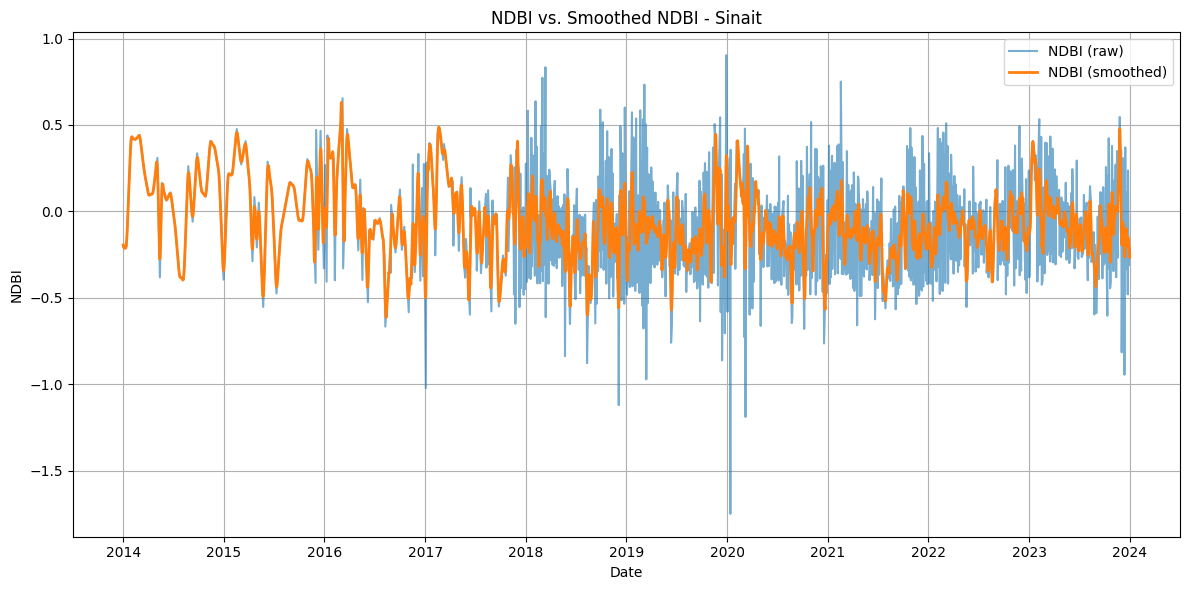

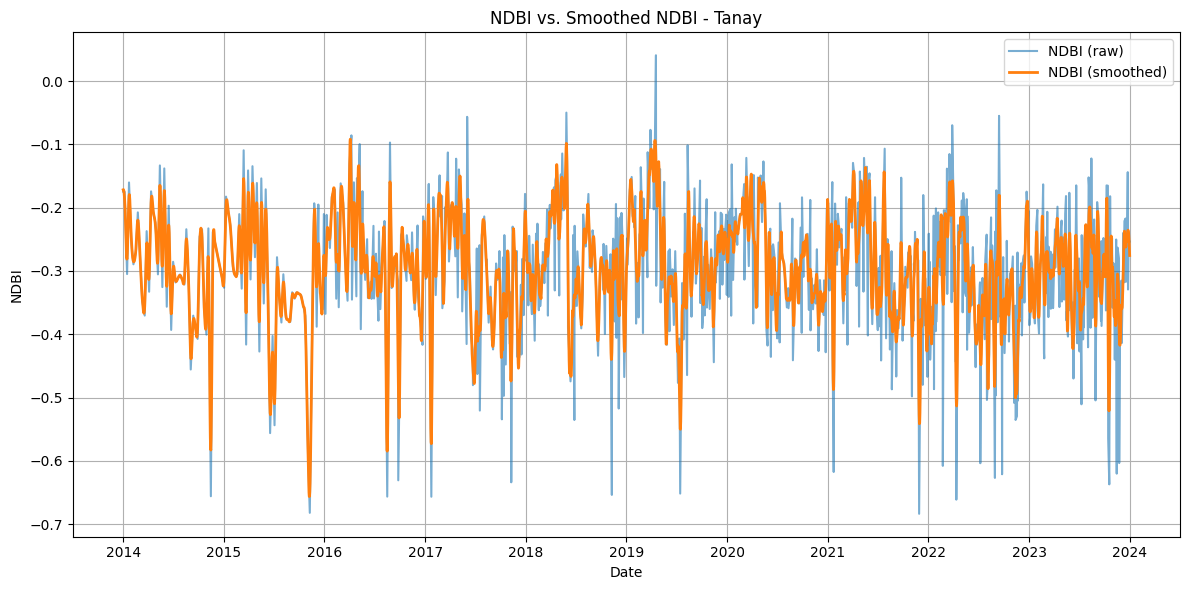

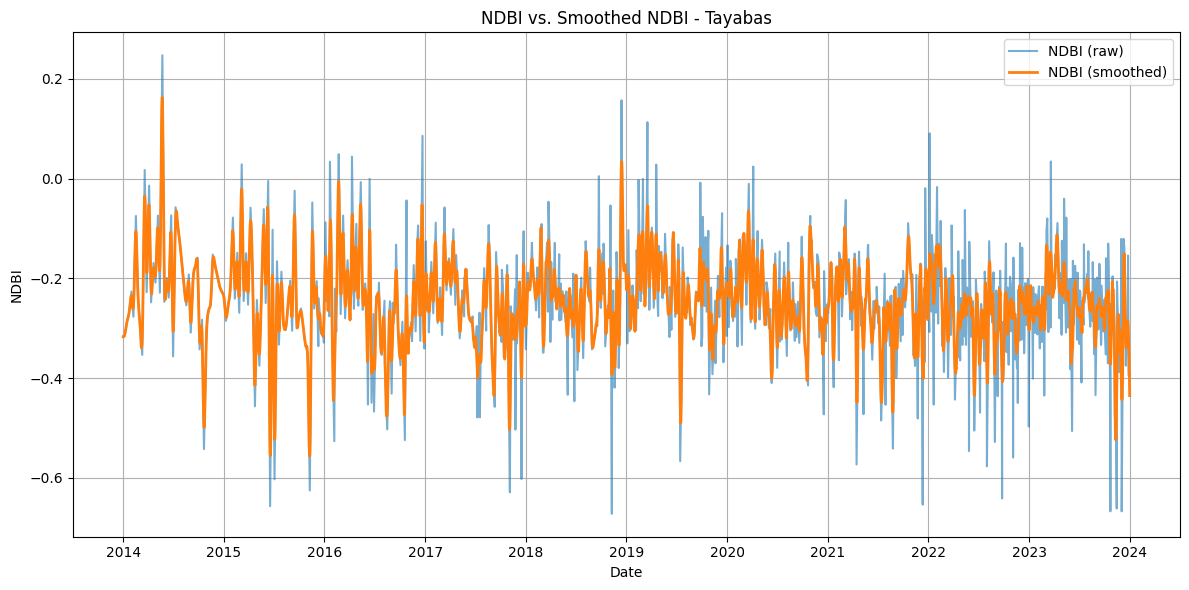

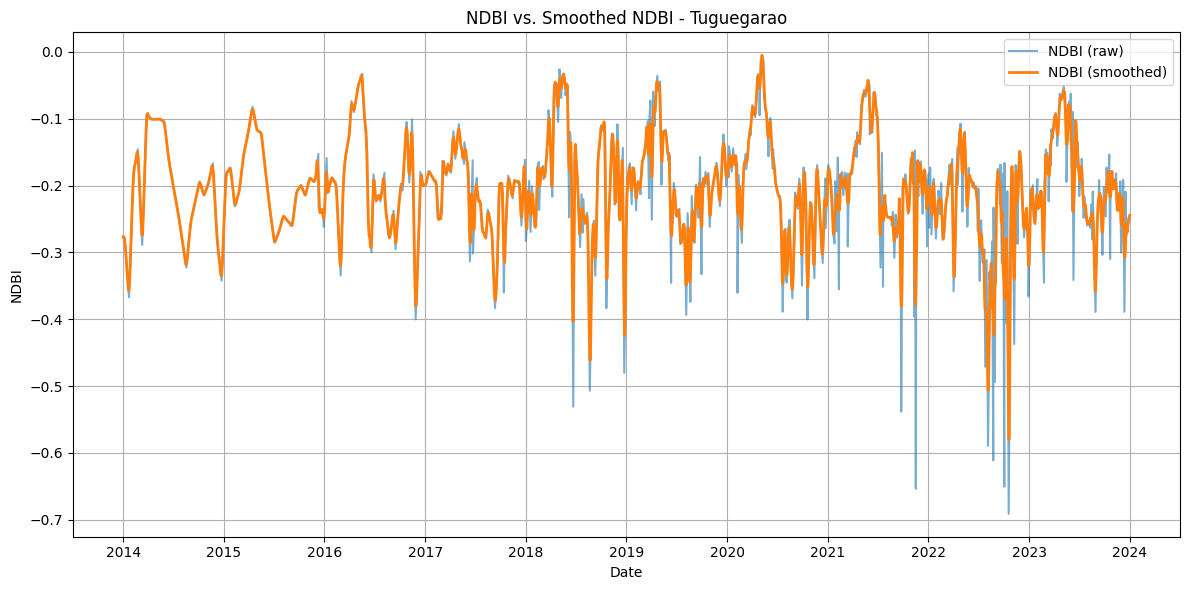

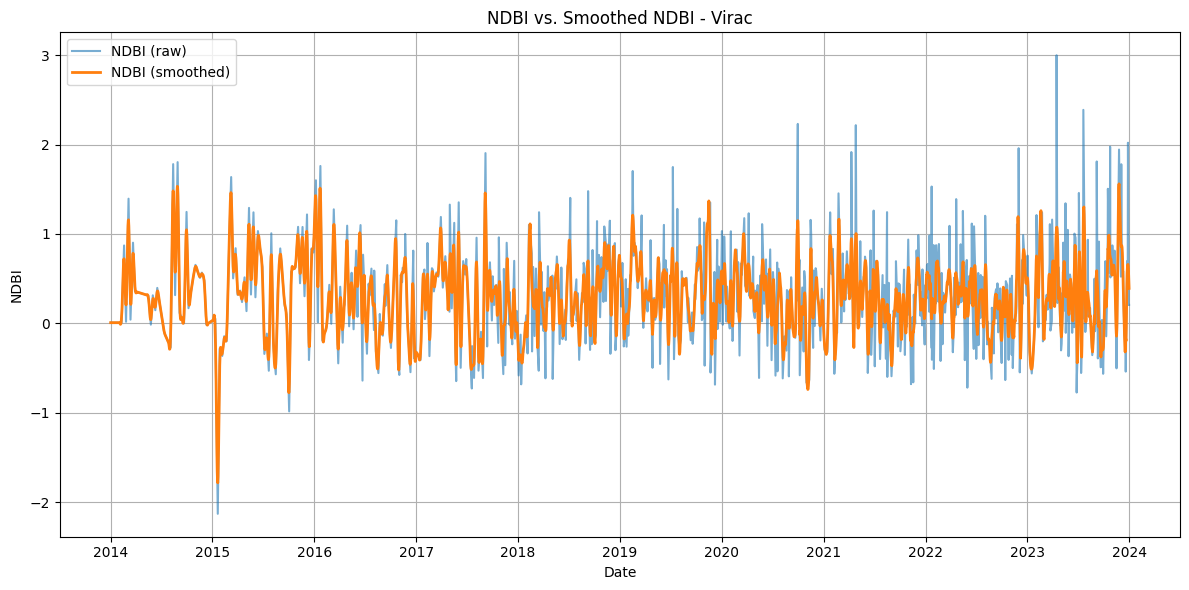

In [67]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_ndbi(csv_file, station_name):
    # Load CSV (expects columns: date, NDBI, NDBI_smooth)
    df = pd.read_csv(csv_file, parse_dates=["date"])

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df["date"], df["NDBI"], label="NDBI (raw)", alpha=0.6)

    if "NDBI_smooth" in df.columns:
        plt.plot(df["date"], df["NDBI_smooth"], label="NDBI (smoothed)", linewidth=2)

    plt.xlabel("Date")
    plt.ylabel("NDBI")
    plt.title(f"NDBI vs. Smoothed NDBI - {station_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

station_names = ["Sinait", "Tanay", "Tayabas", "Tuguegarao", "Virac"]
for station in station_names:
    csv_file = f"{station}_HLS_NDBI.csv"
    plot_ndbi(csv_file, station)
